In [4]:
# 10-1 예나 날씨 데이터 셋 조사하기
import os
fname = os.path.join("jena_climate_2009_2016.csv")   #데이터 합치기

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")    #line의 첫번째 header(칼럼의 이름)를 잡아내고
lines = lines[1:]               # 0은 뺴고 1부터
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [7]:
# 10-2 데이터 파싱
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [26]:
#print(temperature[3])
#print(raw_data[3])

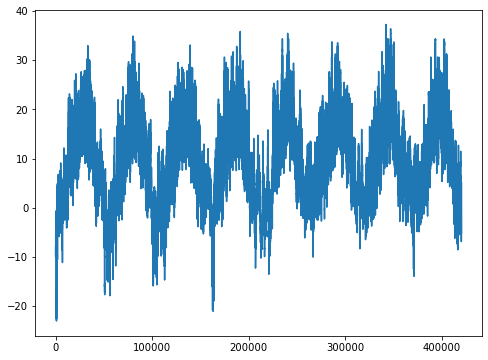

In [23]:
# 10-3 전체 온도를 그래프로 그리기
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)
plt.show()

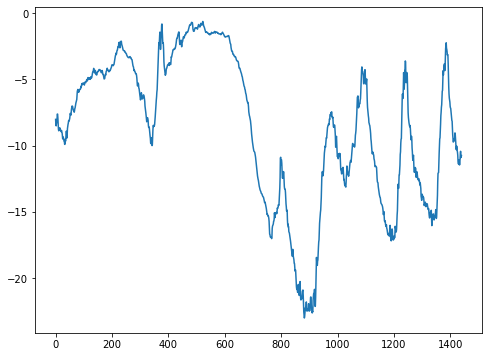

In [22]:
# 10-4 처음 10일간의 온도를 그래프로 그리기
plt.plot(range(1440), temperature[:1440])
plt.show()

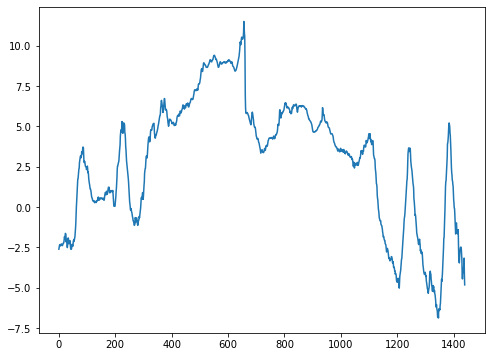

In [28]:
# 최근 10일간 온도를 그래프로 그리기
plt.plot(range(1440), temperature[-1440:])
plt.show()

In [29]:
# 10-5 각 분할에 사용할 샘플 개수 계산하기
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## 10.2.1 데이터 준비

In [30]:
# 10-6 데이터 정규화
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [37]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [38]:
# 10-7 훈련, 검증, 테스트 데이터셋 만들기
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [49]:
# 10-8 훈련 데이터셋의 배치크기 확인하기
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [50]:
## 10.2.2 상식 수준의 기준점
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## 10.2.3 기본적인 머신러닝 모델 시도해보기

- DNN

In [52]:
# 10-10 밀집 연결모델 훈련하고 평가하기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)    # 온도를 예측(회귀)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")   #2.44보다 더 높게 나와야함

Epoch 1/10
819/819 [==============================] - 6s 7ms/step - loss: 13.4101 - mae: 2.8145 - val_loss: 12.2909 - val_mae: 2.7742
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 9.1646 - mae: 2.3802 - val_loss: 12.9928 - val_mae: 2.8656
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 8.4234 - mae: 2.2862 - val_loss: 10.8236 - val_mae: 2.6128
Epoch 4/10
819/819 [==============================] - 7s 8ms/step - loss: 7.9437 - mae: 2.2201 - val_loss: 11.2522 - val_mae: 2.6625
Epoch 5/10
819/819 [==============================] - 6s 8ms/step - loss: 7.6142 - mae: 2.1787 - val_loss: 11.2242 - val_mae: 2.6611
Epoch 6/10
819/819 [==============================] - 7s 9ms/step - loss: 7.3683 - mae: 2.1430 - val_loss: 11.3516 - val_mae: 2.6663
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 7.1450 - mae: 2.1120 - val_loss: 12.8123 - val_mae: 2.8401
Epoch 8/10
819/819 [==============================] - 7s 9ms/step - 

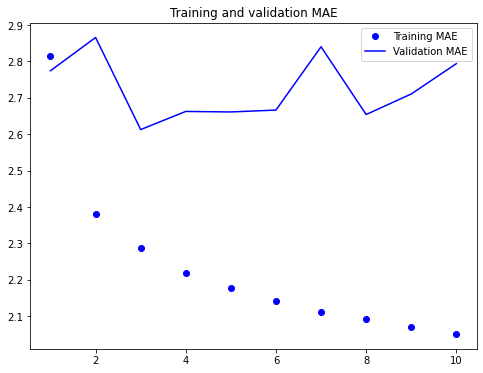

In [53]:
# 10-11 결과 그래프 그리기
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [54]:
## 10.2.4 1D 합성곱 모델 시도해보기
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 20s 23ms/step - loss: 22.6118 - mae: 3.7062 - val_loss: 17.7032 - val_mae: 3.3609
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 15.5633 - mae: 3.1373 - val_loss: 16.3557 - val_mae: 3.1769
Epoch 3/10
819/819 [==============================] - 21s 25ms/step - loss: 14.4533 - mae: 3.0200 - val_loss: 21.9998 - val_mae: 3.7142
Epoch 4/10
819/819 [==============================] - 21s 25ms/step - loss: 13.6439 - mae: 2.9330 - val_loss: 14.6309 - val_mae: 3.0167
Epoch 5/10
819/819 [==============================] - 22s 27ms/step - loss: 13.0146 - mae: 2.8616 - val_loss: 15.0406 - val_mae: 3.0603
Epoch 6/10
819/819 [==============================] - 22s 27ms/step - loss: 12.4996 - mae: 2.8017 - val_loss: 14.3978 - val_mae: 2.9761
Epoch 7/10
819/819 [==============================] - 23s 28ms/step - loss: 12.0642 - mae: 2.7504 - val_loss: 14.5748 - val_mae: 2.9875
Epoch 8/10
819/819 [============================

In [55]:
## 10.2.5 첫번째 순환 신경망
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 35s 40ms/step - loss: 40.8353 - mae: 4.6413 - val_loss: 12.5299 - val_mae: 2.6969
Epoch 2/10
819/819 [==============================] - 38s 46ms/step - loss: 10.8940 - mae: 2.5742 - val_loss: 10.4490 - val_mae: 2.5013
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 9.9463 - mae: 2.4649 - val_loss: 9.5408 - val_mae: 2.4033
Epoch 4/10
819/819 [==============================] - 37s 46ms/step - loss: 9.5895 - mae: 2.4154 - val_loss: 9.5236 - val_mae: 2.4027
Epoch 5/10
819/819 [==============================] - 38s 46ms/step - loss: 9.2133 - mae: 2.3701 - val_loss: 11.2942 - val_mae: 2.4964
Epoch 6/10
819/819 [==============================] - 38s 47ms/step - loss: 8.8891 - mae: 2.3310 - val_loss: 10.7194 - val_mae: 2.4824
Epoch 7/10
819/819 [==============================] - 38s 47ms/step - loss: 8.6528 - mae: 2.3037 - val_loss: 10.9076 - val_mae: 2.4977
Epoch 8/10
819/819 [==============================] - 3

## 10.3 순환 신경망 이해하기

In [ ]:
# 10-3 의사 코드로 표현한 RNN
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

In [ ]:
# 10-14 좀 더 자세한 의사 코드로 표현한 RNN
state = 
for input_t in input_sequece:
    output_t = activation(dot(W, input_t))

In [ ]:
# 10-15 넘파이로 구현한 간단한 RNN
import numpy as np

timesteps = 100
input_features =32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, input_features))
b = np.random.random((output_features,))
successive_outputs:
    for input_t = np.tanh(np.dot(W, input_t)+np.dot(U, state_t)+b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis = 0)